In [1]:
import torch
import math

# Step 1: Generate x values (input space)
def generate_x_values(num_points=100, range_min=-10, range_max=10):
    """
    Generates a tensor of x values uniformly spaced in the given range.
    
    Args:
        num_points (int): Number of points to generate.
        range_min (float): Minimum value of the range.
        range_max (float): Maximum value of the range.

    Returns:
        torch.Tensor: Tensor of shape (num_points,)
    """
    return torch.linspace(range_min, range_max, num_points)

# Step 2: Generate component parameters (mean and std) for each component
def generate_component_params(components, batch_size):
    """
    Generates parameters for each mixture component for a given batch size.
    
    Args:
        components (list of dicts): Each dict should contain 'mean_range' and 'sigma'.
        batch_size (int): Number of samples to generate.

    Returns:
        list of tuples: Each tuple contains (mu, sigma) for a component.
    """
    params = []
    for comp in components:
        mean_range = comp['mean_range']
        sigma = comp['sigma']
        mu = torch.rand(batch_size) * (mean_range[1] - mean_range[0]) + mean_range[0]
        params.append((mu, sigma))
    return params

# Step 3: Evaluate the mixture distribution for each sample
def evaluate_mixture(x, component_params):
    """
    Evaluates the mixture distribution for each sample in the batch.
    
    Args:
        x (torch.Tensor): Input values (shape: [num_points]).
        component_params (list of tuples): (mu, sigma) for each component.

    Returns:
        torch.Tensor: Mixture distribution for each sample (shape: [batch_size, num_points]).
    """
    num_points = x.shape[0]
    batch_size = component_params[0][0].shape[0]
    p = torch.zeros(batch_size, num_points)

    for mu, sigma in component_params:
        # Compute Gaussian for this component
        component_p = torch.exp(- (x.unsqueeze(0) - mu.unsqueeze(1)) ** 2 / (2 * sigma ** 2)) / \
                      (sigma * torch.sqrt(torch.tensor(2 * math.pi)))
        p += component_p

    return p

# Step 4: Normalize the mixture distribution to [-1, 1]
def normalize_data(data):
    """
    Normalizes the data to the range [-1, 1] using min-max scaling.

    Args:
        data (torch.Tensor): Tensor of shape [batch_size, num_points].

    Returns:
        torch.Tensor: Normalized tensor.
    """
    min_vals, _ = data.min(dim=1, keepdim=True)
    max_vals, _ = data.max(dim=1, keepdim=True)
    data = 2 * (data - min_vals) / (max_vals - min_vals) - 1
    return data


# Step 5: Main function to generate the final output
def generate_mixture_data(components, batch_size, num_points=100, range_min=-10, range_max=10):
    """
    Main function to generate mixture data.

    Args:
        components (list of dicts): List of components with 'mean_range' and 'sigma'.
        batch_size (int): Number of samples to generate.
        num_points (int): Number of x points.
        range_min (float): Minimum x value.
        range_max (float): Maximum x value.

    Returns:
        torch.Tensor: Normalized mixture data of shape [batch_size, num_points].
    """
    x = generate_x_values(num_points, range_min, range_max)
    component_params = generate_component_params(components, batch_size)
    mixture_distribution = evaluate_mixture(x, component_params)
    normalized_data = normalize_data(mixture_distribution)
    return normalized_data

In [2]:
import matplotlib.pyplot as plt

def plot_samples(data, x_values, num_samples=2, dpi=100, 
                title="Mixture Distribution Samples", 
                xlabel="X", ylabel="Normalized Value",
                save_path=None):
    """
    Visualize samples from the generated dataset
    
    Args:
        data: Tensor of shape [batch_size, num_points]
        x_values: Tensor of shape [num_points] for x-axis
        num_samples: Number of samples to plot
        dpi: Figure resolution
        title: Plot title
        xlabel: X-axis label
        ylabel: Y-axis label
        save_path: If provided, saves figure to this path
    """
    # Ensure we don't request more samples than available
    num_samples = min(num_samples, data.shape[0])
    
    plt.figure(figsize=(12, 4 * num_samples), dpi=dpi)
    
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i+1)
        plt.plot(x_values, data[i], color='blue', linewidth=2)
        plt.grid(True, alpha=0.3)
        plt.title(f"Sample {i+1}", fontsize=10)
        plt.xlabel(xlabel, fontsize=8)
        plt.ylabel(ylabel, fontsize=8)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    else:
        plt.show()
    plt.close()

In [3]:
# Generate data using your function
components = [
    {'mean_range': (-15, -5), 'sigma': 1.0},
    {'mean_range': (5, 15), 'sigma': 1.0}
]
batch_size = 100
num_points = 100
range_min, range_max = -20, 20

data = generate_mixture_data(components, batch_size, num_points, range_min, range_max)
x_values = torch.linspace(range_min, range_max, num_points)

print(data.shape)  # Output: torch.Size([10, 100])

torch.Size([100, 100])


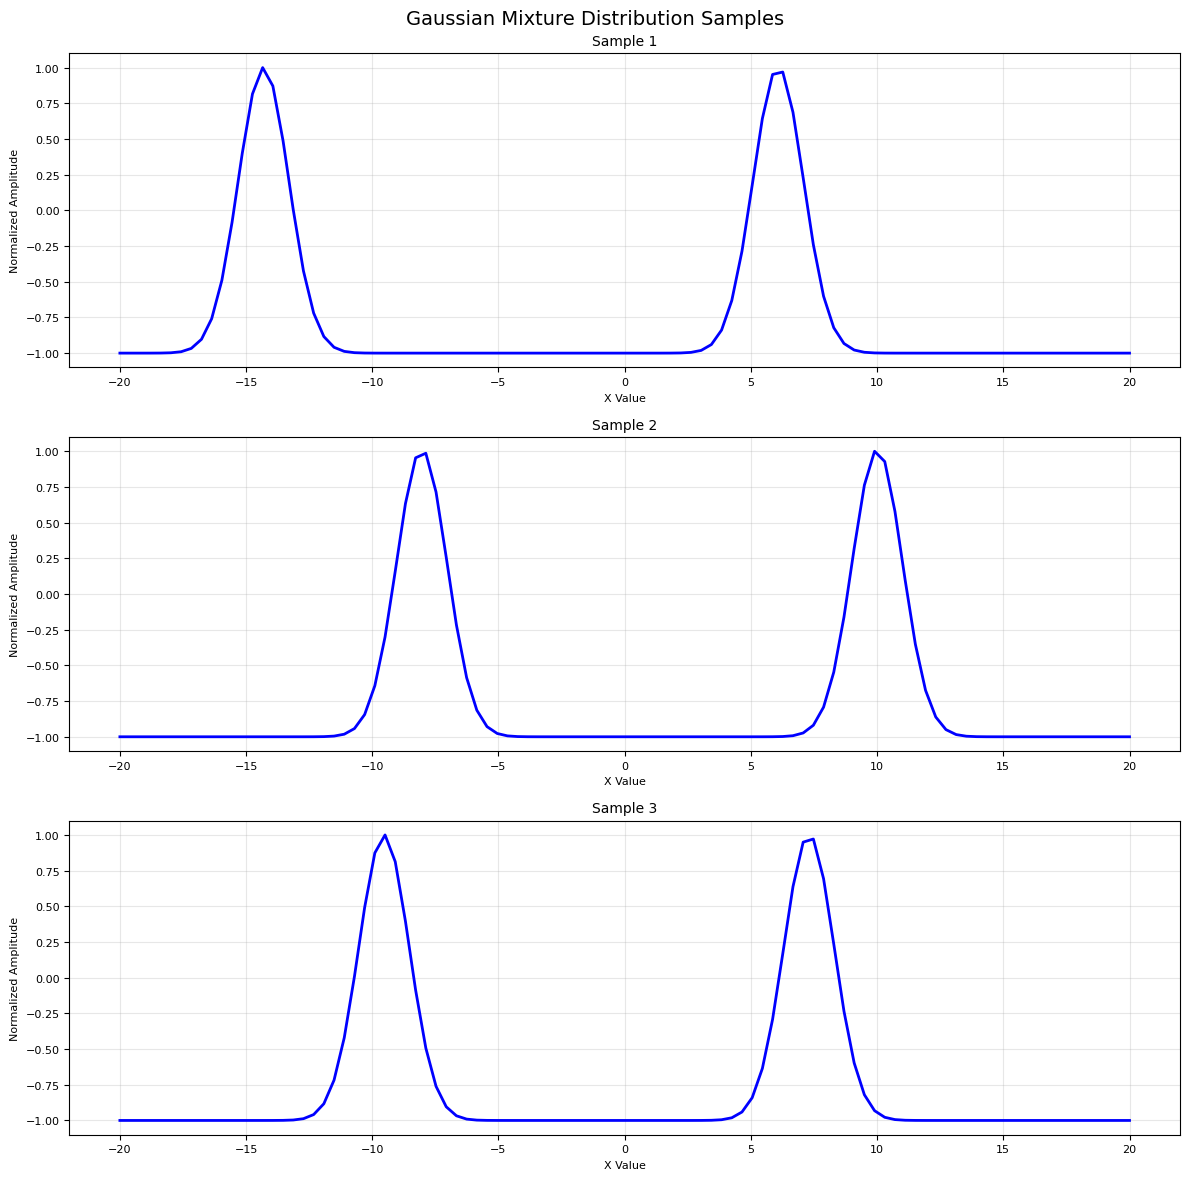

In [4]:
# Visualize samples
plot_samples(
    data=data,
    x_values=x_values,
    num_samples=3,
    title="Gaussian Mixture Distribution Samples",
    xlabel="X Value",
    ylabel="Normalized Amplitude"
)

In [14]:
# Generate data using your function
components = [
    {'mean_range': (-15, -5), 'sigma': 1.0},
    {'mean_range': (5, 15), 'sigma': 1.0},
    {'mean_range': (0, 5), 'sigma': 2.0},
    {'mean_range': (-5, 0), 'sigma': 2.0}
]
batch_size = 100
num_points = 200
range_min, range_max = -30, 30

data = generate_mixture_data(components, batch_size, num_points, range_min, range_max)
x_values = torch.linspace(range_min, range_max, num_points)

print(data.shape)  # Output: torch.Size([10, 100])

torch.Size([100, 200])


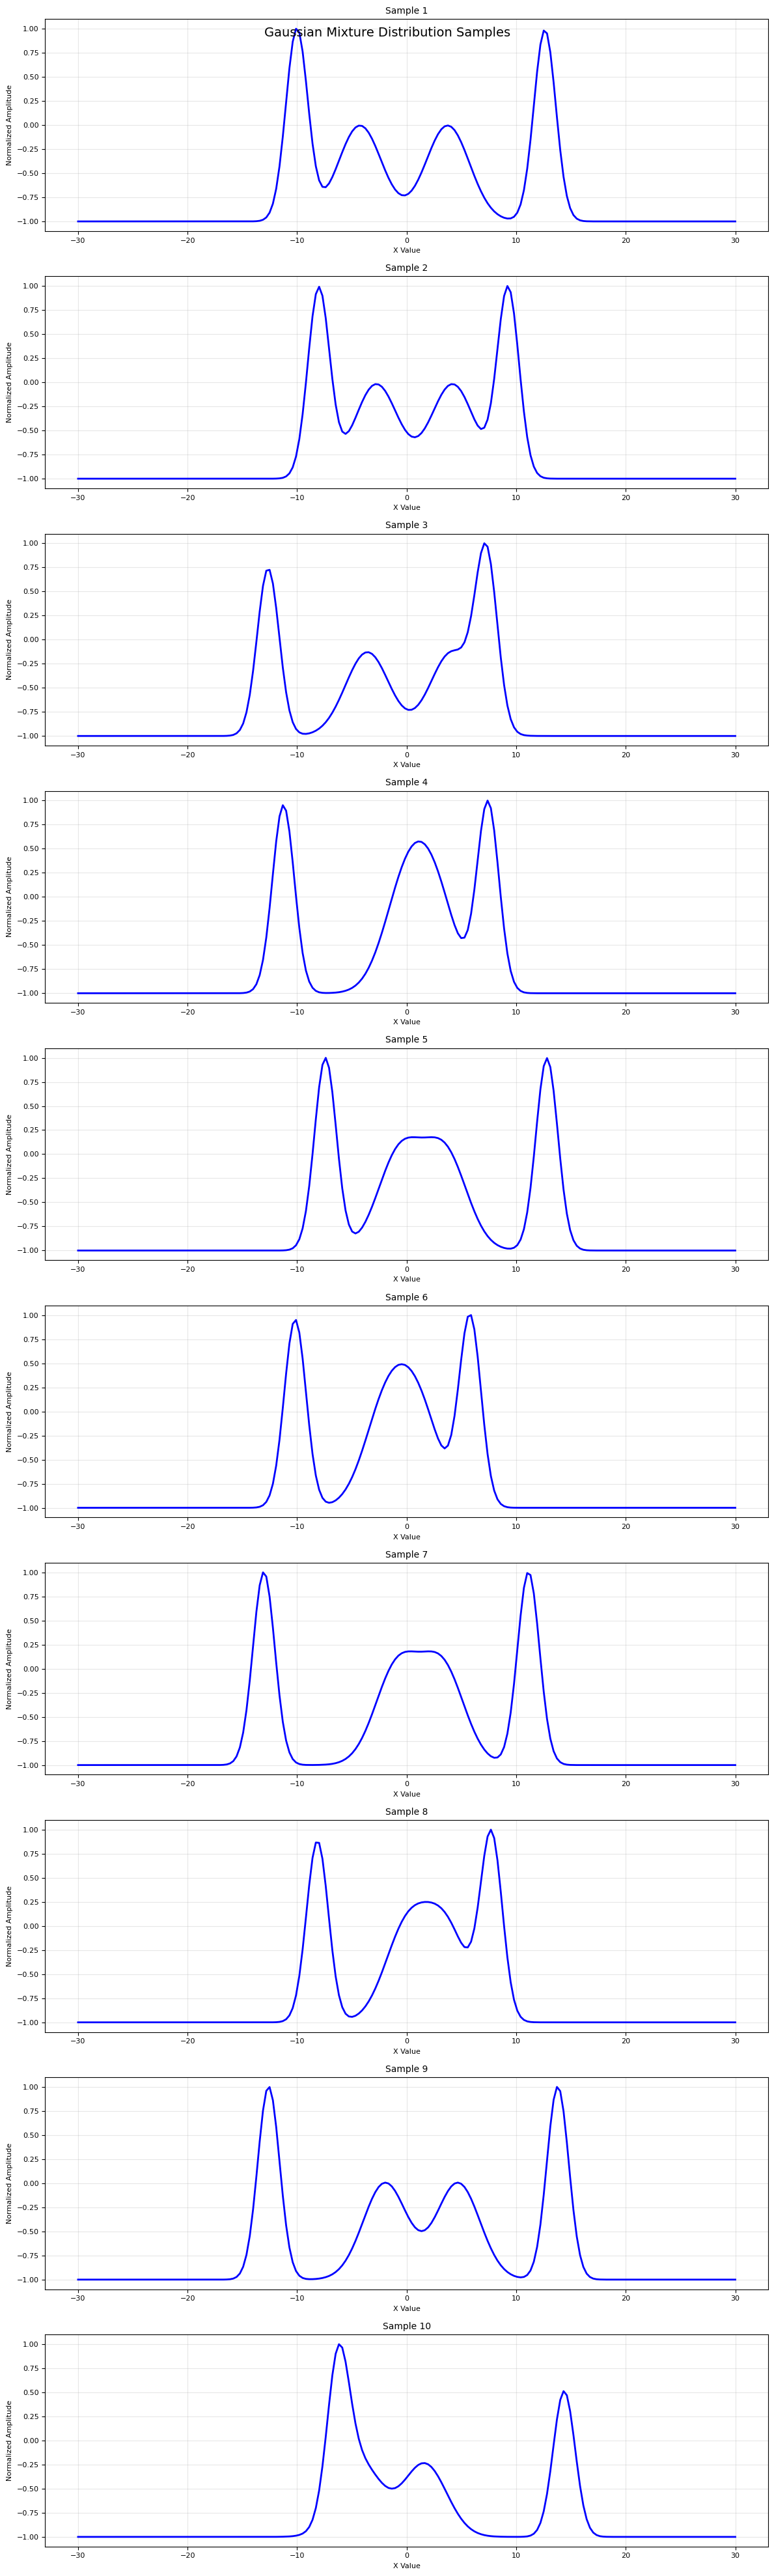

In [15]:
# Visualize samples
plot_samples(
    data=data,
    x_values=x_values,
    num_samples=10,
    title="Gaussian Mixture Distribution Samples",
    xlabel="X Value",
    ylabel="Normalized Amplitude"
)